# Ch 6 - Basics of Probability and Statistics
This notebook contains python code for generating figures in the Chapter 6 of the book _Mathematics in Biology_.

## Imports and utilities

In [ ]:
import numpy as np
import random
from random import seed

from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import poisson, binom, t, norm, chi2, uniform, expon
from scipy import special

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('..\img')
    savedir.mkdir(parents=True, exist_ok=True)

datadir = Path('data')

In [6]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

## Basics

### Random variables

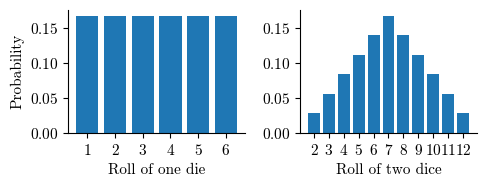

In [7]:
fig = plt.figure(figsize=(5,2))
X = [1,2,3,4,5,6]
Y=[1/6,1/6,1/6,1/6,1/6,1/6]
ax = fig.add_subplot(121)
barplot1=ax.bar(X, Y)
ax.set_xticks(X)
ax.set_xlabel('Roll of one die')
ax.set_ylabel('Probability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(122)
X = [2,3,4,5,6,7,8,9,10,11,12]
Y= [1/36,2/36,3/36,4/36,5/36,1/6,5/36,4/36,3/36,2/36,1/36]
barplot2=ax.bar(X, Y)
ax.set_xticks(X)
ax.set_xlabel('Roll of two dice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Distribution-Two-Dice.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Important probability distributions

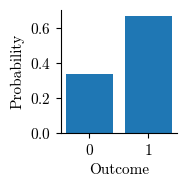

In [8]:
fig = plt.figure(figsize=(2,2))
X = [0,1]
Y=[1/3,2/3]
ax = fig.add_subplot(111)
barplot1=ax.bar(X, Y)
ax.set_xticks(X)
ax.set_xlabel("Outcome")
ax.set_ylabel("Probability")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Distribution-Bernoulli.pdf'), dpi=600, format='pdf', bbox_inches='tight');

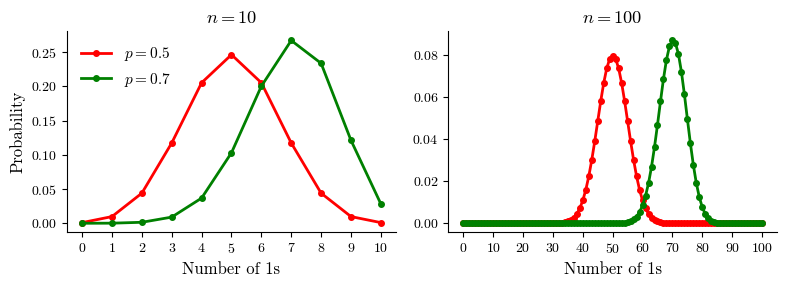

In [9]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121)
n=10
p=[0.5,0.7]
L=['$p={}$'.format(p[i]) for i in range(len(p))]
X=np.arange(n+1)
Y=[binom.pmf(X,n,p[i]) for i in range(len(p))]
plot(X,Y,xlabel='Number of 1s',ylabel='Probability',
    fmts=['r-o','g-o'],markersize=4,
    legend=L,title='$n={}$'.format(n),xticks=X.tolist(),
    axes=ax)
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2 = fig.add_subplot(122)
n=100
p=[0.5,0.7]
L=['$p={}$'.format(p[i]) for i in range(len(p))]
X=np.arange(n+1)
Y=[binom.pmf(X,n,p[i]) for i in range(len(p))]
plot(X,Y,xlabel='Number of 1s',
    fmts=['r-o','g-o'],markersize=4,
    title='$n={}$'.format(n),xticks=np.arange(0,n+1,10).tolist(),
    axes=ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Distribution-Binomial.pdf'), dpi=600, format='pdf', bbox_inches='tight');

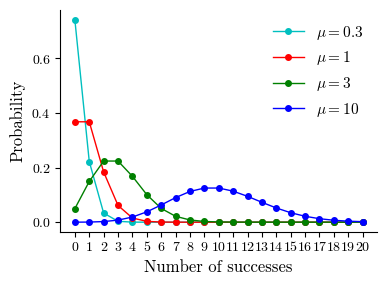

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
mu=[0.3,1,3,10] # values of mu
xmax=20 # range of m
L=['$\mu={}$'.format(mu[i]) for i in range(len(mu))] # legends
xticks=np.arange(xmax+1).tolist()
lticks=[0,1,2,3,4,5,10,15,20] # ticks with labels on them
X=np.arange(xmax+1)
Y=[poisson.pmf(X,mu[i]) for i in range(len(mu))]
plot(X,Y,xlabel='Number of successes',ylabel='Probability',
        fmts=['c-o','r-o','g-o','b-o'],markersize=4,linewidth=1,xticks=xticks,
        legend=L,axes=ax)
ax.set_xticklabels(['{:d}'.format(t) if t in xticks else '' for t in xticks])
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Distribution-Poisson.pdf'), dpi=600, format='pdf', bbox_inches='tight');

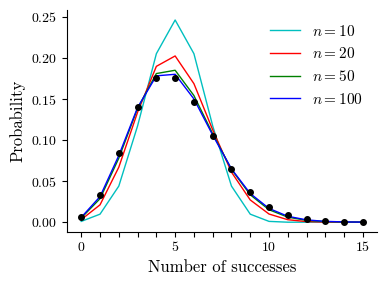

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
mu=5 # values of mu
n=[10,20,50,100]
xmax=15 # range of m
L=['$n={}$'.format(n[i]) for i in range(len(n))] # legends
xticks=np.arange(xmax+1).tolist() # ticks with marks
lticks=[0,5,10,15] # ticks with labels
X=np.arange(xmax+1)
Y=[binom.pmf(X,n[i],mu/n[i]) for i in range(len(n))]+[poisson.pmf(X,mu)]
plot(X,Y,xlabel='Number of successes',ylabel='Probability',
    fmts=['c-','r-','g-','b-','ko'],markersize=4,linewidth=1,xticks=xticks,
    legend=L, axes=ax)
ax.set_xticklabels(['{:d}'.format(t) if t in lticks else '' for t in xticks])
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Distribution-Poiss-Binom.pdf'), dpi=600, format='pdf', bbox_inches='tight');

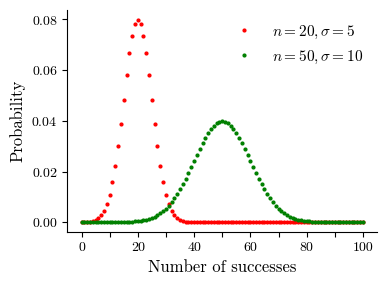

In [12]:
fig, ax = plt.subplots(figsize=(4,3))
mu=[20,50] # values of mu
si=[5,10] # values of sigma
xmax=100 # range of m
L=['$n={:d},\sigma={:d}$'.format(mu[i],si[i]) for i in range(len(mu))] # legends
xticks=np.arange(0,xmax+1,10).tolist() # ticks with marks
lticks=[0,20,40,60,80,100] # ticks with labels
X=np.arange(xmax+1)
Y=[np.exp(-(X-mu[i])**2/2/si[i]**2)/np.sqrt(2*np.pi)/si[i] for i in range(len(mu))]
plot(X,Y,xlabel='Number of successes',ylabel='Probability',
    fmts=['r-o','g-o','b-o','c-o','ko'],markersize=2,linewidth=0,xticks=xticks,
    legend=L, axes=ax)
ax.set_xticklabels(['{:d}'.format(t) if t in lticks else '' for t in xticks])
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Distribution-Gauss.pdf'), dpi=600, format='pdf', bbox_inches='tight');

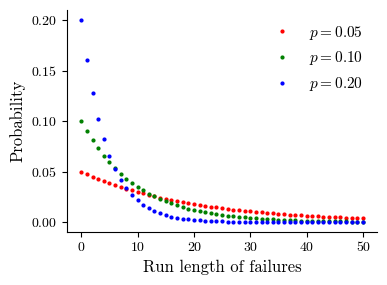

In [13]:
fig, ax = plt.subplots(figsize=(4,3))
p=[0.05,0.1,0.2] # values of mu
xmax=50 # range of m
L=['$p={:.2f}$'.format(p[i]) for i in range(len(p))] # legends
xticks=np.arange(0,xmax+1,10).tolist() # ticks with marks
lticks=[0,10,20,30,40,50] # ticks with labels
X=np.arange(xmax+1)
Y=[p[i]*(1-p[i])**X for i in range(len(p))]
plot(X,Y,xlabel='Run length of failures',ylabel='Probability',
    fmts=['r-o','g-o','b-o','c-o','ko'],markersize=2,linewidth=0,xticks=xticks,
    legend=L, axes=ax)
ax.set_xticklabels(['{:d}'.format(t) if t in lticks else '' for t in xticks])
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Geometric.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Continuous random variables

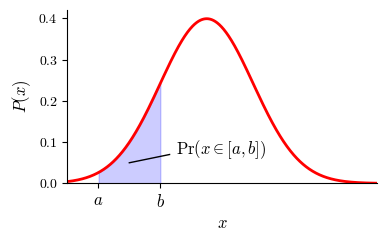

In [14]:
mu=-0.5
si=1.5
a,b=-4,-2
def f(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/si**2)
x=np.arange(-5,5,0.01)
fig, ax = plt.subplots(figsize=(4,2.5))
plot(x,f(x),yzero=True,ylim=[0,0.42],xlim=[-5,5],xlabel='$x$',ylabel='$P(x)$', axes=ax)
ax.fill_between(x,f(x),where=np.logical_and(x>a,x<b),color='blue',alpha=0.2)
plot([-3,-1.7],[0.05,0.07],fmts='k-',linewidth=1, axes=ax)
ax.set_xticks([a,b])
ax.set_xticklabels(['$a$','$b$'],fontsize=12)
ax.text(-1.5,0.07,'$\mathrm{Pr}(x \in [a,b])$',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Prob-Density.pdf'), dpi=600, format='pdf', bbox_inches='tight');

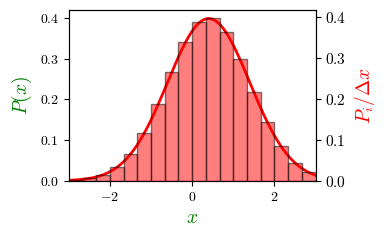

In [15]:
# Continuous and discrete
def f(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/si**2)
mu=0.4
si=1
dx=1/3
a,b=-3,3
x=np.arange(a,b,0.01)
y=np.arange(a+dx/2,b+dx/2,dx)
bins=np.arange(a+dx/2,b+dx+dx/2,dx)
fig, ax1 = plt.subplots(figsize=(4,2.5))
plot(x,f(x),yzero=True,ylim=[0,0.42],xlim=[a,b],axes=ax1)
ax1.set_ylabel('$P(x)$',fontsize=14,color='g')
ax1.set_xlabel('$x$',fontsize=14,color='g')
ax2=ax1.twinx()
ax2.hist(y,bins=bins,weights=f(y),align='left',rwidth=1.0,color='red',alpha=0.5,edgecolor='black');
ax2.set_ylabel('$P_i/\Delta x$',fontsize=14,color='r')
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Prob-Cont-Discr.pdf'), dpi=600, format='pdf', bbox_inches='tight');

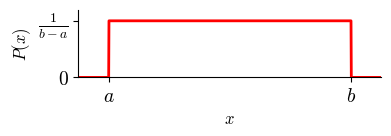

In [16]:
# Uniform distribution
a,b=-4,4
def f(x):
    return np.where(np.logical_and(x>a,x<b),1/(b-a),0)
x=np.arange(-5,5,0.01)
fig, ax = plt.subplots(figsize=(4,1.5))
plot(x,f(x),yzero=True,xlim=[-5,5],ylim=[0,1.2/(b-a)],xlabel='$x$',ylabel='$P(x)$', axes=ax)
ax.set_xticks([a,b])
ax.set_xticklabels(['$a$','$b$'],fontsize=14)
ax.set_yticks([0,1/(b-a)])
ax.set_yticklabels([r'$0$',r'$\frac{1}{b-a}$'],fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Prob-Dens-Uniform.pdf'), dpi=600, format='pdf', bbox_inches='tight');

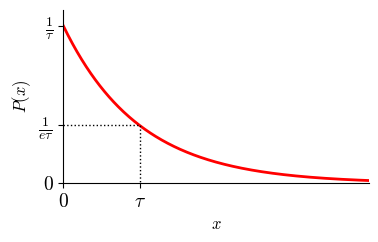

In [17]:
# Exponential distribution
ta=1 # tau
def f(x):
    return np.exp(-x/ta)/ta
x=np.arange(0,4,0.01)
fig, ax = plt.subplots(figsize=(4,2.5))
plot(x,f(x),yzero=True,xlabel='$x$',ylabel='$P(x)$',
       xlim=[0,4],ylim=[0,1.1/ta], axes=ax)
plot([0,ta,ta],[1/np.e/ta,1/np.e/ta,0],fmts=['k:'],linewidth=1, axes=ax)
ax.set_xticks([0,ta])
ax.set_xticklabels([r'$0$',r'$\tau$'],fontsize=14)
ax.set_yticks([0,1/ta/np.e,1/ta])
ax.set_yticklabels([r'$0$',r'$\frac{1}{e\tau}$',r'$\frac{1}{\tau}$'],fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Prob-Dens-Expon.pdf'), dpi=600, format='pdf', bbox_inches='tight');

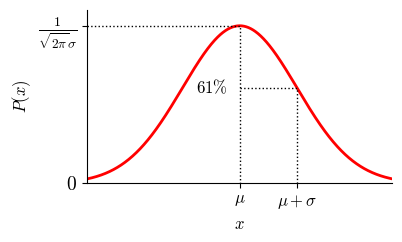

In [18]:
# Gaussian
mu=0
si=1.5
a,b=-4,4
def f(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/si**2)
x=np.arange(a,b,0.01)
fig, ax = plt.subplots(figsize=(4,2.5))
plot(x,f(x),yzero=True,xlabel='$x$',ylabel='$P(x)$', axes=ax)
plot([a,mu,mu],[f(0),f(0),0],fmts=['k:'],linewidth=1, axes=ax)
plot([-0,mu+si,mu+si],[f(mu+si),f(mu+si),0],fmts=['k:'],linewidth=1,
       ylim=[0,1.1*f(0)],xlim=[a,b], axes=ax)
ax.set_xticks([0,si])
ax.set_xticklabels([r'$\mu$',r'$\mu+\sigma$'],fontsize=12)
ax.set_yticks([0,f(0)])
ax.set_yticklabels([r'$0$',r'$\frac{1}{\sqrt{2\pi}\sigma}$'],fontsize=14)
ax.text(-1.15,0.57*f(0),r'${:.0f}\%$'.format(np.exp(-0.5)*100),fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'Prob-Dens-Gauss.pdf'), dpi=600, format='pdf', bbox_inches='tight');

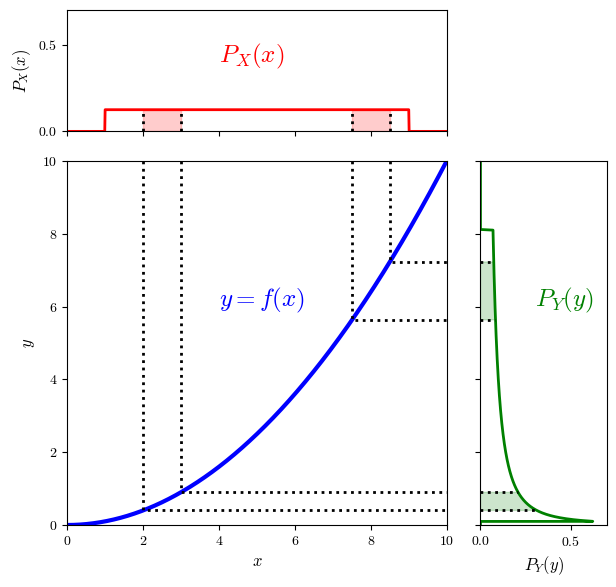

In [19]:
# Function of a random variable
xl,xh,xn=0,10,1000 # low and high x, number of x values
a,b=1,9 # range of the uniform distribution
def f(x):
    return x**2/10
def unif(x,a,b):
    return np.where(np.logical_and(x>=a,x<b),1/(b-a),0)
x = np.linspace(xl,xh,xn)
px=unif(x,a,b)
y=f(x)
yl,yh=np.min(y),np.max(y)
py=np.copy(px)
py[:-1]*=np.abs((x[1:]-x[:-1])/(y[1:]-y[:-1]))
py[-1]=0 #append a zero
x1,x2,x3,x4=2,3,7.5,8.5
px1,px2,px3,px4=px[np.where(x>x1)[0][0]],px[np.where(x>x2)[0][0]],px[np.where(x>x3)[0][0]],px[np.where(x>x4)[0][0]]
y1,y2,y3,y4=f(x1),f(x2),f(x3),f(x4)
py1,py2,py3,py4=py[np.where(y>y1)[0][0]],py[np.where(y>y2)[0][0]],py[np.where(y>y3)[0][0]],py[np.where(y>y4)[0][0]]
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(6.3,6),
                      gridspec_kw={'width_ratios':[3,1],'height_ratios':[1,3]})
ax=axes[0,0]
plot(x,px,xlim=[xl,xh],ylim=[0,0.7],ylabel=r'$P_X(x)$',fmts=['r-'], axes=ax)
ax.fill_between(x,px,where=np.logical_or(np.logical_and(x>x1,x<x2),np.logical_and(x>x3,x<x4)),
                  color='red',alpha=0.2)
ax.text(4,0.4,r'$P_X(x)$',fontsize=18,color='red')
plot([[x1,x1],[x2,x2],[x3,x3],[x4,x4]],[[0,px1],[0,px2],[0,px3],[0,px4]],yticks=[0,0.5],
     fmts=['k:','k:','k:','k:'], axes=ax)
ax.tick_params(labelbottom=False)
ax=axes[1,0]
plot(x,y,xlim=[xl,xh],ylim=[yl,yh],xlabel=r'$x$',ylabel=r'$y$',fmts=['b-'],linewidth=3,axes=ax)
plot([[x1,x1,xh],[x2,x2,xh],[x3,x3,xh],[x4,x4,xh]],[[yh,y1,y1],[yh,y2,y2],[yh,y3,y3],[yh,y4,y4]],
     fmts=['k:','k:','k:','k:'],axes=ax)
ax.text(4,6,r'$y=f(x)$',fontsize=18,color='blue')
ax=axes[1,1];
plot(py,y,xlim=[0,0.7],ylim=[yl,yh],xlabel=r'$P_Y(y)$',fmts=['g-'], axes=ax)
ax.fill_betweenx(y,py,where=np.logical_or(np.logical_and(y>y1,y<y2),np.logical_and(y>y3,y<y4)),
                  color='green',alpha=0.2)
plot([[0,py1],[0,py2],[0,py3],[0,py4]],[[y1,y1],[y2,y2],[y3,y3],[y4,y4]],
     fmts=['k:','k:','k:','k:'],xticks=[0,0.5], axes=ax)
ax.text(0.3,6,r'$P_Y(y)$',fontsize=18,color='green');
ax.tick_params(labelleft=False);
axes[0,1].axis('off');
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Prob-Func-of-RV.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Multiple random variables

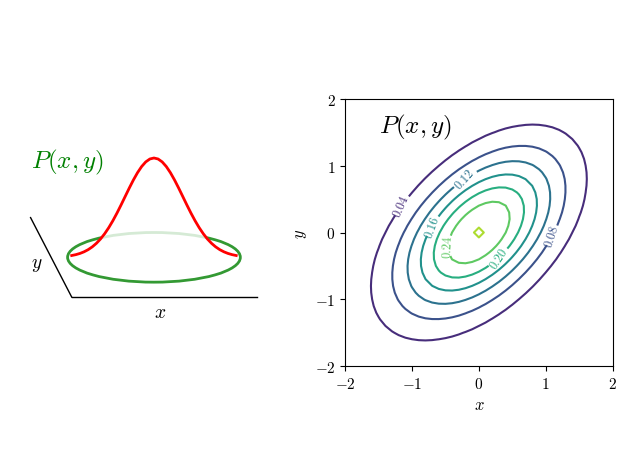

In [20]:
# 2D Gaussian drawings
fig, axes = plt.subplots(nrows=1,ncols=2)
ax=axes[0]
x=np.linspace(-2, 2, 41)
y=np.exp(-x**2)
plot(x,y,axes=ax);
e1=patches.Ellipse((0,0), width=4.2, height=0.5, color='green',
                     angle=0, linewidth=2, fill=False, zorder=0,alpha=0.8)
ax.add_patch(e1)
ax.fill_between(x,y,color='white',alpha=0.8)
plot([-2,-3],[-0.4,0.4],fmts=['k-'],linewidth=1,axes=ax);
plot([-2,2.5],[-0.4,-0.4],fmts=['k-'],linewidth=1,xlim=[-3.5,3],ylim=[-2,2.5],axes=ax);
ax.text(0,-0.6,r'$x$',fontsize=14);
ax.text(-3,-0.1,r'$y$',fontsize=14);
ax.text(-3,0.9,r'$P(x,y)$',fontsize=18,color='green');
ax.axis('off');
ax=axes[1]
def f(x, y):
    return np.exp(-(x ** 2 - x*y + y ** 2))
x=np.linspace(-2, 2, 41)
y=np.linspace(-2, 2, 41)
X,Y=np.meshgrid(x, y)
Z=f(X, Y)
Z/=np.sum(Z)*0.01
CS = ax.contour(X,Y,Z);
ax.clabel(CS,inline=1,fontsize=9,fmt='%1.2f');
ax.set_xlabel(r'$x$',fontsize=12);
ax.set_ylabel(r'$y$',fontsize=12);
ax.set_aspect(1);
ax.set_xticks([-2,-1,0,1,2]);
ax.set_yticks([-2,-1,0,1,2]);
ax.text(-1.5,1.5,r'$P(x,y)$',fontsize=18);
fig.tight_layout();
if Save:
    fig.savefig(str(savedir / 'Prob-Joint-Density-Draw.pdf'), dpi=600, format='pdf', bbox_inches='tight');

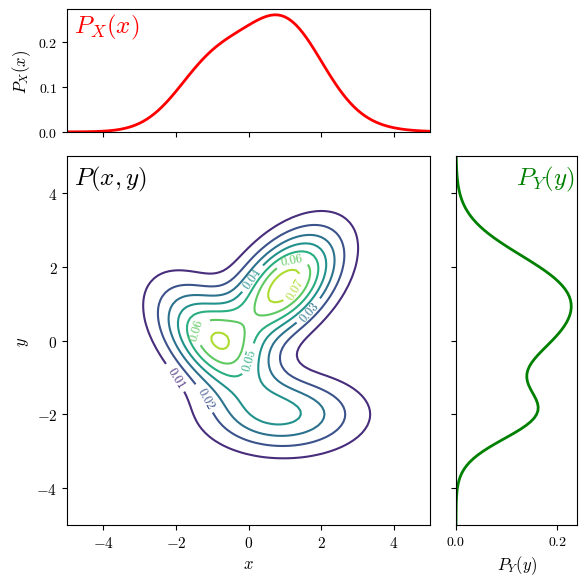

In [21]:
def xCx(x,C):
    '''
    Quadratic form x^T * C * x
    x = single n-dim vector, or arbitrary array of such vectors
    C = nxn matrix
    return has shape of x without the last dimension
    '''
    return np.sum(np.dot(x,C)*x,axis=-1)

# Gaussian prob array version
def GaussN(x,M,C):
    '''
    n-dim Gaussian with mean M and covariance C
    x = single n-dim vector, or arbitrary array of such vectors
    return has shape of x without the last dimension
    '''
    return np.exp(-xCx(x-M,np.linalg.inv(C))/2)/np.sqrt((2*np.pi)**x.shape[-1]*np.linalg.det(C))

# Marginal prob with mix of Gaussians
M1=np.array([1,1.5]) # Mean of first Gaussian
C1=np.array([[1,0.5],[0.5,1]]) # Covar of first Gaussian
M2=np.array([-1,0])
C2=np.array([[1,-0.5],[-0.5,1]])
M3=np.array([1,-2])
C3=np.array([[2,0],[0,0.5]])
x=np.linspace(-5,5,101) # set up the grid
y=np.linspace(-5,5,101)
X,Y=np.meshgrid(x,y)
U=np.stack((X,Y),axis=-1) # a vector for every grid point
P=GaussN(U,M1,C1)+0.8*GaussN(U,M2,C2)+0.6*GaussN(U,M3,C3) # mixture of 3 gaussians
P/=(np.sum(P)*0.01) # normalize
PX=np.sum(P,axis=0)*0.1 # marginal prob of X
PY=np.sum(P,axis=1)*0.1 # marginal prob of Y
xlim=[-5,5] # limits for the plot
ylim=[-5,5]
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(6,6),
                      gridspec_kw={'width_ratios':[3,1],'height_ratios':[1,3]})
ax=axes[0,0] # plot P_X(x)
plot(x,PX,ylabel=r'$P_X(x)$',fmts=['r-'],xlim=xlim,axes=ax);
ax.set_ylim(bottom=0);
ax.text(0.02,0.98,r'$P_X(x)$',fontsize=18,color='red',transform = ax.transAxes,ha='left',va='top');
ax.tick_params(labelbottom=False);
ax=axes[1,0] # plot P(x,y)
CS = ax.contour(X,Y,P)
ax.clabel(CS,inline=1,fontsize=9,fmt='%1.2f');
ax.set_xlim(xlim[0],xlim[1]);
ax.set_ylim(ylim[0],ylim[1]);
ax.set_xlabel(r'$x$',fontsize=12);
ax.set_ylabel(r'$y$',fontsize=12);
ax.text(0.02,0.98,r'$P(x,y)$',fontsize=18,transform = ax.transAxes,ha='left',va='top');
ax=axes[1,1] # plot P_Y(y)
plot(PY,y,xlabel=r'$P_Y(y)$',fmts=['g-'],ylim=ylim,xlim=[],axes=ax);
ax.set_xlim(left=0);
ax.text(0.98,0.98,r'$P_Y(y)$',fontsize=18,color='green',transform = ax.transAxes,ha='right',va='top');
ax.tick_params(labelleft=False);
axes[0,1].axis('off');
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Prob-Marginal.pdf'), dpi=600, format='pdf', bbox_inches='tight');

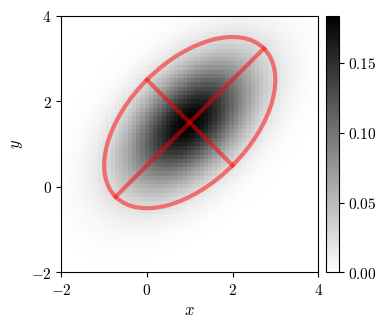

In [22]:
# Gaussian gray scale with ellipses and principal axes
M=np.array([1,1.5]) # Mean of Gaussian
C=np.array([[1,0.5],[0.5,1]]) # Covar of Gaussian
xl,xh=-5,5 # x range for the function
yl,yh=-5,5 # y range for the function
xlim=[-2,4] # x limits for the plot
ylim=[-2,4] # y limits for the plot
S=2 # number of SDs for the ellipse
x=np.linspace(xl,xh,101) # set up the grid
y=np.linspace(yl,yh,101)
X,Y=np.meshgrid(x,y)
U=np.stack((X,Y),axis=-1) # a vector for every grid point
P=GaussN(U,M,C) # Gaussian
fig,ax=plt.subplots(1,1,figsize=(4,4))
im=ax.imshow(P,cmap='gray_r',vmin=0,extent=[xl,xh,yl,yh], origin='lower')
divider = make_axes_locatable(ax) # this way of adding colorbar is compatible with tight_layout
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im,cax=cax,ticks=[0,0.05,0.1,0.15]);
ax.set_xlim(xlim[0],xlim[1]);
ax.set_ylim(ylim[0],ylim[1]);
ax.set_aspect('equal', 'box');
ax.set_xlabel(r'$x$',fontsize=12);
ax.set_ylabel(r'$y$',fontsize=12);
ax.set_xticks([-2,0,2,4]);
ax.set_yticks([-2,0,2,4]);
w,v=np.linalg.eigh(C) # find eigenvales and vectors of C. These are the variance along the principal axes.
el=patches.Ellipse(M,width=2*S*np.sqrt(w[0]),height=2*S*np.sqrt(w[1]), # ellipse with principal axes
                   color='red',angle=np.math.atan(v[0][1]/v[0][0])*180/np.pi,
                   linewidth=3,fill=False,zorder=2,alpha=0.5)
ax.add_patch(el); # plot the ellipse
ax.plot([M[0]-S*np.sqrt(w[0])*v[0,0],M[0]+S*np.sqrt(w[0])*v[0,0]], # draw the principal axes
        [M[1]-S*np.sqrt(w[0])*v[0,1],M[1]+S*np.sqrt(w[0])*v[0,1]],color='red',linewidth=3,zorder=3,alpha=0.5);
ax.plot([M[0]-S*np.sqrt(w[1])*v[1,0],M[0]+S*np.sqrt(w[1])*v[1,0]],
        [M[1]-S*np.sqrt(w[1])*v[1,1],M[1]+S*np.sqrt(w[1])*v[1,1]],color='red',linewidth=3,zorder=4,alpha=0.5);
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Prob-Gauss-Axes.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### The Central Limit Theorem

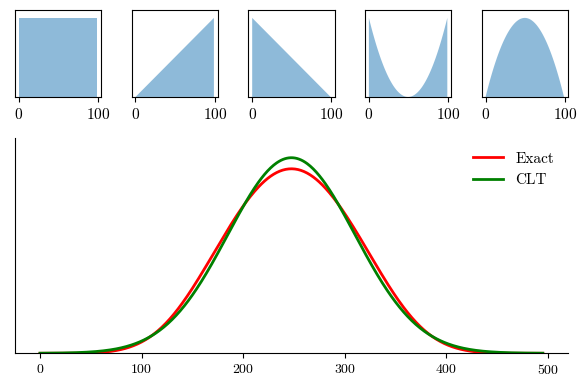

In [23]:
def Mean(x,p): 
    '''
    Mean of the probability distribution p(x)
    ''' 
    return np.sum(p*x)

def Var(x,p):
    '''
    Variance of the probability distribution p(x)
    ''' 
    return Mean(x**2,p)-Mean(x,p)**2

def Std(x,p):
    '''
    Standard deviation of the probability distribution p(x)
    ''' 
    return np.sqrt(Var(x,p))
    
n=100
m=5 # number of variables summed
x=np.arange(n)
p=np.zeros((m,n))
p[0]=1 # uniform
p[1]=x # ramp up
p[2]=n-1-x # ramp down
p[3]=(x/(n-1)-0.5)**2 # quadratic
p[4]=0.5**2-(x/(n-1)-0.5)**2 # inverted quadratic
p/=np.sum(p,axis=-1).reshape(-1,1) # normalize all
q=np.copy(p[0])
for i in range(1,m): # convolve all to get sum distrn
    q=np.convolve(q,p[i])
y=np.arange(q.shape[0])
mu=Mean(y,q) # mean of sum distrn
si=Std(y,q) # std of sum distrn
g=1/np.sqrt(2*np.pi)/si*np.exp(-(y-mu)**2/2/si**2) # gaussian

fig = plt.figure(figsize=(6,4))
for i in range(m):
    ax=plt.subplot2grid((3,m),(0,i),colspan=1)
    ax.fill_between(x,p[i],'b',alpha=0.5);
    ax.set_yticks([]);
    ax.set_xticks([0,100]);
    ax.set_ylim(ymin=0,ymax=np.max(p[i])*1.1);
ax=plt.subplot2grid((3,m),(1,0),colspan=m,rowspan=2)
plot([q,g],fmts=['r-','g-'],legend=['Exact','CLT'],
     ylim=[0,np.max(g)*1.1],yhide=True,axes=ax);
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout();
if Save:
    fig.savefig(str(savedir / 'Prob-CLT-Five.pdf'), dpi=600, format='pdf', bbox_inches='tight');

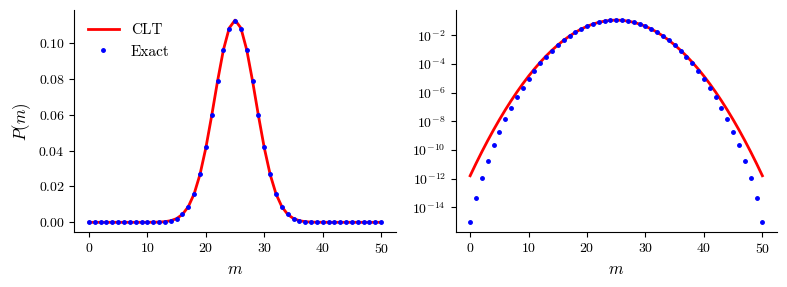

In [24]:
n=50
x=np.arange(n+1)
p=binom.pmf(x,n,0.5)
mu=Mean(x,p)
si=Std(x,p)
g=1/np.sqrt(2*np.pi)/si*np.exp(-(x-mu)**2/2/si**2) # gaussian
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,3))
legend=['CLT','Exact']
plot(x,[g,p],fmts=['r-','b.'],
    xlabel=r'$m$',ylabel=r'$P(m)$',axes=axes[0]);
plot(x,[g,p],fmts=['r-','b.'],yscale='log',
    xlabel=r'$m$',axes=axes[1]);
axes[0].legend(legend, loc='upper left')
axes[0].legend_.set_frame_on(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'Prob-CLT-Central.pdf'), dpi=600, format='pdf', bbox_inches='tight');